In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [43]:
##Importing modules

import os
import pandas as pd
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
import librosa
import librosa.display 
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [7]:
##Load Data

##Extracting labels
paths = []
labels = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append((os.path.join(dirname, filename)))
        label = filename.split('_')[2]
        label = label.split('.')[0]
        labels.append(label.lower())
        
setlist = set(labels)
print(setlist)

{'disgust', 'ps', 'sad', 'neutral', 'fear', 'happy', 'angry'}


In [8]:
## Creating Data frame

df = pd.DataFrame()

df['input_path'] = paths
# speech, label
df['emotion_type'] = labels

df.head()
df['emotion_type'].value_counts()

emotion_type
fear       800
angry      800
disgust    800
neutral    800
sad        800
ps         800
happy      800
Name: count, dtype: int64

In [9]:
# Feature Extraction using MFCC
# y is data and sr is sampling rate
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc= np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T, axis =0)
    return mfcc
    
    

In [10]:
extract_mfcc(df['input_path'][0])

array([-285.73727   ,   85.78295   ,   -2.1689112 ,   22.125532  ,
        -14.757395  ,   11.051346  ,   12.412449  ,   -3.0002618 ,
          1.0844991 ,   11.078272  ,  -17.41966   ,   -8.093213  ,
          6.5879726 ,   -4.2209535 ,   -9.15508   ,    3.52148   ,
        -13.186381  ,   14.078853  ,   19.66973   ,   22.725618  ,
         32.57464   ,   16.325035  ,   -3.8427293 ,    0.89629656,
        -11.239262  ,    6.653462  ,   -2.5883696 ,   -7.7140164 ,
        -10.941658  ,   -2.4007547 ,   -5.281288  ,    4.271157  ,
        -11.202216  ,   -9.024621  ,   -3.6669848 ,    4.869744  ,
         -1.6027985 ,    2.5600514 ,   11.454374  ,   11.233449  ],
      dtype=float32)

In [11]:
# Iterating through all files and extracting features

X_mfcc = df['input_path'].apply(lambda complete_path: extract_mfcc(complete_path))

In [12]:
X_mfcc

0       [-285.73727, 85.78295, -2.1689112, 22.125532, ...
1       [-348.34332, 35.193233, -3.841328, 14.658875, ...
2       [-340.11435, 53.796444, -14.267782, 20.884027,...
3       [-306.63422, 21.259708, -4.4110823, 6.4871554,...
4       [-344.7548, 46.329193, -24.171413, 19.392921, ...
                              ...                        
5595    [-374.3952, 60.864998, 0.025059083, 8.431058, ...
5596    [-313.96478, 39.847843, -5.6493053, -3.867575,...
5597    [-357.54886, 77.886055, -15.224756, 2.194633, ...
5598    [-353.1474, 101.68391, -14.175896, -12.037376,...
5599    [-389.4595, 54.042767, 1.346998, -1.4258983, -...
Name: input_path, Length: 5600, dtype: object

In [18]:
# Covert df to 2D array 

X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [19]:
# Use lSTM model
# input split
X= np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [34]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['emotion_type']])
# y[0]
y = y.toarray()

# **Create LSTM model**

In [35]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(123, return_sequences = False, input_shape=(40,1)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7,activation="softmax") # 7 for 7 categories
])

model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 123)               61500     
                                                                 
 dense_4 (Dense)             (None, 64)                7936      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 7)                 231       
                                                                 
Total params: 71747 (280.26 KB)
Trainable params: 7174

# **Train the model**



In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4200, 40, 1), (4200, 7), (1400, 40, 1), (1400, 7))

In [54]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs =100, batch_size=512,shuffle=True)

Epoch 1/100
9/9 [==============================] - 2s 207ms/step - loss: 2.6974e-04 - accuracy: 1.0000 - val_loss: 0.0072 - val_accuracy: 0.9971
Epoch 2/100
9/9 [==============================] - 2s 198ms/step - loss: 1.9043e-04 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 0.9971
Epoch 3/100
9/9 [==============================] - 2s 195ms/step - loss: 5.4173e-04 - accuracy: 0.9998 - val_loss: 0.0064 - val_accuracy: 0.9971
Epoch 4/100
9/9 [==============================] - 2s 195ms/step - loss: 2.0562e-04 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9971
Epoch 5/100
9/9 [==============================] - 2s 195ms/step - loss: 7.5942e-04 - accuracy: 0.9998 - val_loss: 0.0059 - val_accuracy: 0.9971
Epoch 6/100
9/9 [==============================] - 2s 196ms/step - loss: 2.1801e-04 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9986
Epoch 7/100
9/9 [==============================] - 2s 195ms/step - loss: 3.6021e-04 - accuracy: 1.0000 - val_loss: 0.0052 - val_ac

44/44 [==============================] - 1s 17ms/step - loss: 4.8077e-05 - accuracy: 1.0000
Accuracy of our model on test data :  100.0 %


ValueError: x and y must have same first dimension, but have shapes (50,) and (100,)

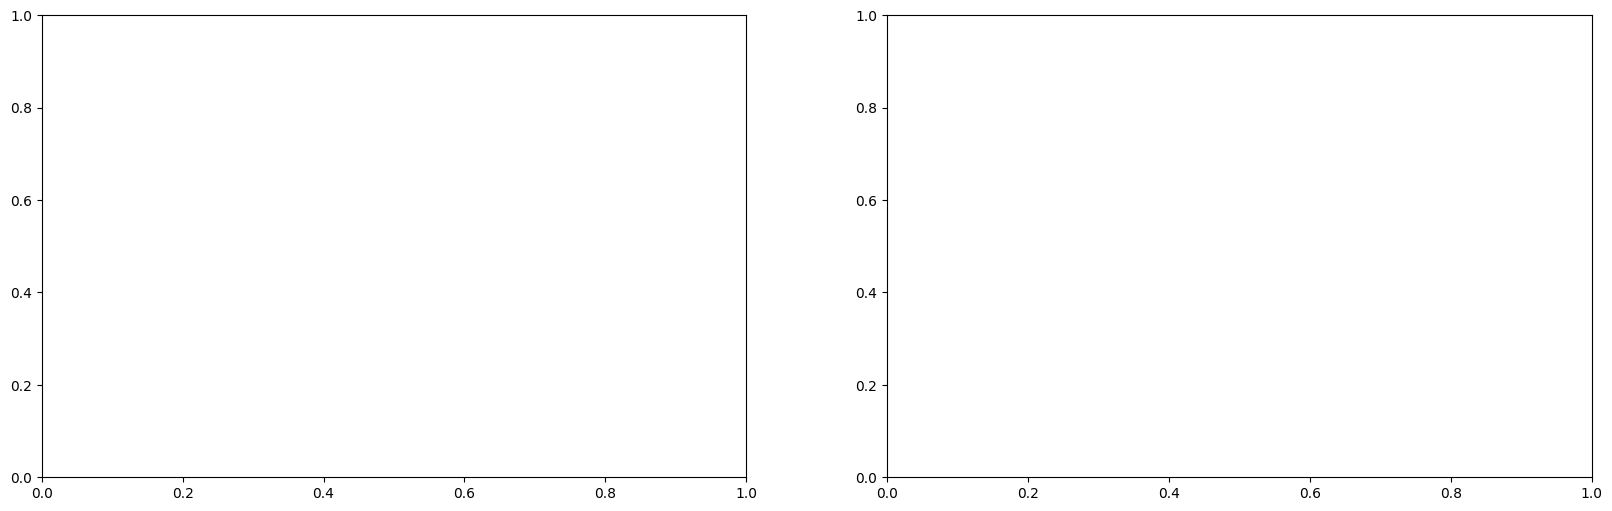

In [55]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [56]:
pred_test = model.predict(x_test)
y_pred = enc.inverse_transform(pred_test)

y_test = enc.inverse_transform(y_test)

44/44 [==============================] - 1s 17ms/step


In [58]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(100)

,Predicted Labels,Actual Labels
0,disgust,disgust
1,disgust,disgust
2,neutral,neutral
3,angry,angry
4,angry,angry
...,...,...
95,sad,sad
96,ps,ps
97,angry,angry
98,neutral,neutral


In [59]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       197
     disgust       1.00      1.00      1.00       207
        fear       1.00      1.00      1.00       203
       happy       1.00      1.00      1.00       200
     neutral       1.00      1.00      1.00       198
          ps       1.00      1.00      1.00       208
         sad       1.00      1.00      1.00       187

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400

